## This Notebook is dedicated to build research work on imputing the Smart-Meter 6 hour interval and 15 minute interval data effectviely

### We have previously tested

1) Simple foreward fill propogating the last known value forward
2) Linear interpolation assuming the consective consumptions are relatively smooth
3) Spline interpolation assuming complex structures of consumption
4) Polynomial interpolation
5) Moving Average

But since those methods doesnt consider the household information, we are hoping to establish a robust imputing methodlogy incorporating such household data

The below graph shows the current datapoint density graph for Smart-meter 15 min interval dataset

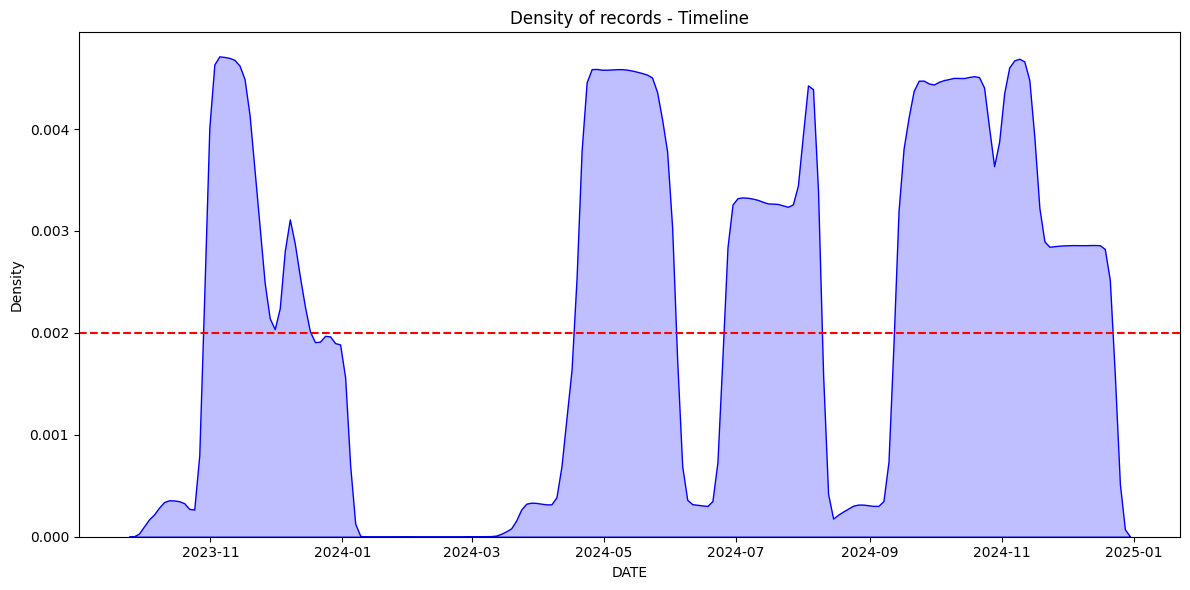

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

all_data = pd.DataFrame()
total = 0

wave_1_houseinfo = pd.read_csv('/home/chanuka/code/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
wave_1_houseinfo = wave_1_houseinfo[['household_ID', 'socio_economic_class', 'no_of_household_members']]

for root, folder, files in os.walk('/home/chanuka/code/SL_electricity_consumption/data/consumption_data/smart_meter/15min_interval'):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, low_memory=False)
            all_data = pd.concat([all_data, data], ignore_index=True)
            rows, cols = data.shape
            total = total + rows

all_data_filtered = all_data[['household_ID', 'date', 'time', 'importkwh(kwh)', 'exportkwh(kwh)']].copy()
all_data_filtered = all_data_filtered[all_data_filtered['household_ID'].isin(wave_1_houseinfo['household_ID'])]

all_data_filtered['time'] = all_data_filtered['time'].str.extract(r'(\d{2}:\d{2}:\d{2})')

all_data_filtered['DATETIME'] = pd.to_datetime(all_data_filtered['date'] + ' ' + all_data_filtered['time'], errors='coerce')

all_data_filtered['importkwh(kwh)'] = pd.to_numeric(all_data_filtered['importkwh(kwh)'], errors='coerce')
all_data_filtered['exportkwh(kwh)'] = pd.to_numeric(all_data_filtered['exportkwh(kwh)'], errors='coerce')

all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

all_data_filtered[['importkwh(kwh)', 'exportkwh(kwh)']] = (
    all_data_filtered.groupby('household_ID')[['importkwh(kwh)', 'exportkwh(kwh)']].diff()
)

negatives = all_data_filtered[
    (all_data_filtered['importkwh(kwh)'] < 0) |
    (all_data_filtered['exportkwh(kwh)'] < 0)
]

all_data_filtered = all_data_filtered.drop(negatives.index)

# Kernel Density Estimation (KDE) probability density function

plt.figure(figsize=(12, 6))
density_threshold = 0.002

sns.kdeplot(all_data_filtered['DATETIME'], fill=True, color='blue', bw_adjust=0.5)
plt.axhline(y=density_threshold, color='red', linestyle='--', label='Density Threshold = 0.002')
plt.title('Density of records - Timeline')
plt.xlabel('DATE')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### As shown in the graph, there are time periods during which no data points were recorded for any household by the electricity provider. However, there is a light at the end of the tunnel. Due to the cumulative nature of electricity consumption measurements, we know the actual total consumption that occurred between the missing time periods. This opens the doors to effectively impute the missing intervals by properly distributing the known cumulative consumption across the gap, rather than losing that information entirely.

### Step 01: Creating a Dataset of complete 15 min interval timepoints for all the households and merging our current dataset into it

In [3]:
all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

def create_complete_dataset_vectorized(data):
    
    households = data['household_ID'].unique()
    min_date = data['DATETIME'].min()
    max_date = data['DATETIME'].max()
    full_time_index = pd.date_range(start=min_date, end=max_date, freq='15min')
    full_index = pd.MultiIndex.from_product([households, full_time_index], names=['household_ID', 'DATETIME'])
    full_df = pd.DataFrame(index=full_index).reset_index()

    return pd.merge(full_df, data, on=['household_ID', 'DATETIME'], how='left')

complete_data = create_complete_dataset_vectorized(all_data_filtered)

'''#creating a complete dataset interms of date and time
def create_complete_dataset(data):
    all_data = pd.DataFrame()
    households = data['household_ID'].unique()

    for household in households:
        household_data = data[data['household_ID'] == household]
        date_range = pd.date_range(start=household_data['DATETIME'].min(), end=household_data['DATETIME'].max(), freq='15min')
        complete_data = pd.DataFrame({'DATETIME': date_range})
        complete_data['household_ID'] = household
        complete_data = pd.merge(complete_data, household_data, on=['household_ID', 'DATETIME'], how='left')
        all_data = pd.concat([all_data, complete_data], ignore_index=True)

    return all_data

complete_data = create_complete_dataset(all_data_filtered)'''

"#creating a complete dataset interms of date and time\ndef create_complete_dataset(data):\n    all_data = pd.DataFrame()\n    households = data['household_ID'].unique()\n\n    for household in households:\n        household_data = data[data['household_ID'] == household]\n        date_range = pd.date_range(start=household_data['DATETIME'].min(), end=household_data['DATETIME'].max(), freq='15min')\n        complete_data = pd.DataFrame({'DATETIME': date_range})\n        complete_data['household_ID'] = household\n        complete_data = pd.merge(complete_data, household_data, on=['household_ID', 'DATETIME'], how='left')\n        all_data = pd.concat([all_data, complete_data], ignore_index=True)\n\n    return all_data\n\ncomplete_data = create_complete_dataset(all_data_filtered)"

In [ ]:
#these are by considering household IDs
def remove_leading_missing_consumption(data, value_col='importkwh(kwh)'):
    data = data.sort_values(['household_ID', 'DATETIME'])
    first_valid_time = (
        data[data[value_col].notnull()]
        .groupby('household_ID')['DATETIME']
        .min()
        .reset_index()
        .rename(columns={'DATETIME': 'first_valid_DATETIME'})
    )
    data = data.merge(first_valid_time, on='household_ID', how='left')
    return data[data['DATETIME'] >= data['first_valid_DATETIME']].drop(columns=['first_valid_DATETIME'])

complete_data = remove_leading_missing_consumption(complete_data)


def remove_ending_missing_consumption(data, value_col='importkwh(kwh)'):
    data = data.sort_values(['household_ID', 'DATETIME'])
    last_valid_time = (
        data[data[value_col].notnull()]
        .groupby('household_ID')['DATETIME']
        .max()
        .reset_index()
        .rename(columns={'DATETIME': 'last_valid_DATETIME'})
    )
    data = data.merge(last_valid_time, on='household_ID', how='left')
    return data[data['DATETIME'] <= data['last_valid_DATETIME']].drop(columns=['last_valid_DATETIME'])

complete_data = remove_ending_missing_consumption(complete_data)

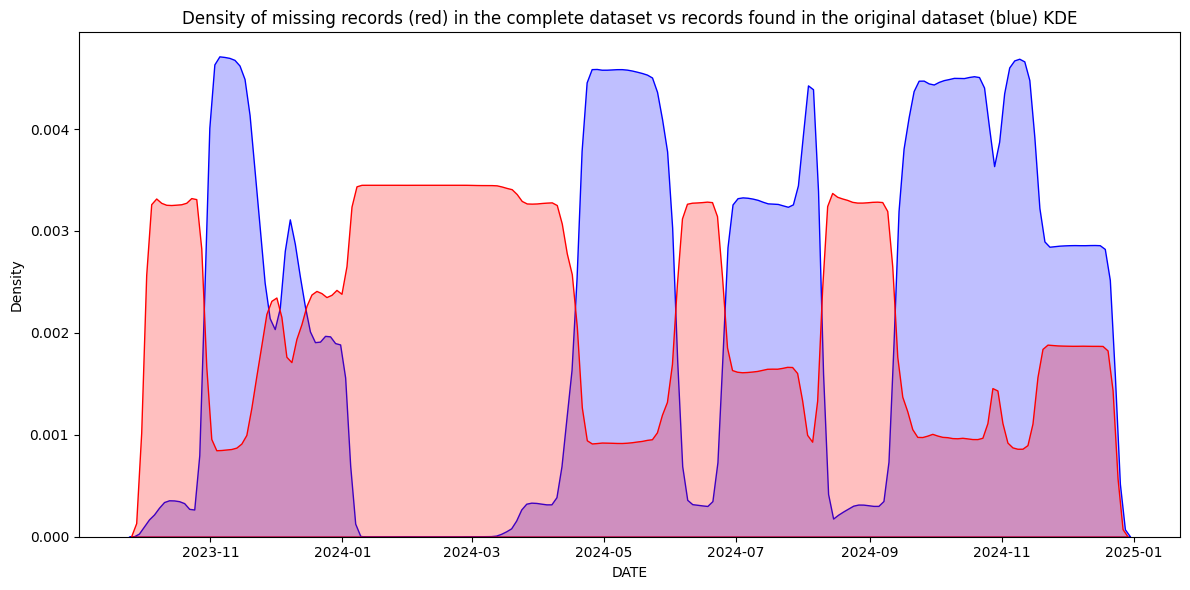

In [4]:
plt.figure(figsize=(12, 6))
sns.kdeplot(all_data_filtered['DATETIME'].dropna(), fill=True, color='blue', bw_adjust=0.5)
sns.kdeplot(complete_data[complete_data['importkwh(kwh)'].isna()]['DATETIME'], fill=True, color='red', bw_adjust=0.5)
plt.title('Density of missing records (red) in the complete dataset vs records found in the original dataset (blue) KDE')
plt.xlabel('DATE')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Step 02: Filling Missing Data Points Using Interpolation Based on Household Characteristics

Here we construct a consumption weights dictionary for each 15min of the day. This dictionary considers, the number of household members and the socio-economic class of the household. These weights are then used to distribute the missing consumption proportionally across the time interval. (Note: The socio economic class is derived by considering the education level and the occupation of the chief wage owner)


#### Step 02.01: Creating a weight dictionary for every 15min of the day

In [58]:
# selecting the most dense period of time for creating the imputation model

all_data_dense = all_data_filtered[all_data_filtered['DATETIME'] >= '2024-09-01']
# remove the first datapoint of every households
all_data_dense = all_data_dense[~all_data_dense['DATETIME'].isin(all_data_dense.groupby('household_ID')['DATETIME'].first())]

# Removing noise: rows if importkwh(kwh) > 50 
all_data_dense = all_data_dense[all_data_dense['importkwh(kwh)'] <= 50]
all_data_dense = all_data_dense.merge(wave_1_houseinfo, on='household_ID', how='left')

#### Step 02.01.01: General Daily Consumption Trend in Sri Lanka

<Axes: xlabel='time'>

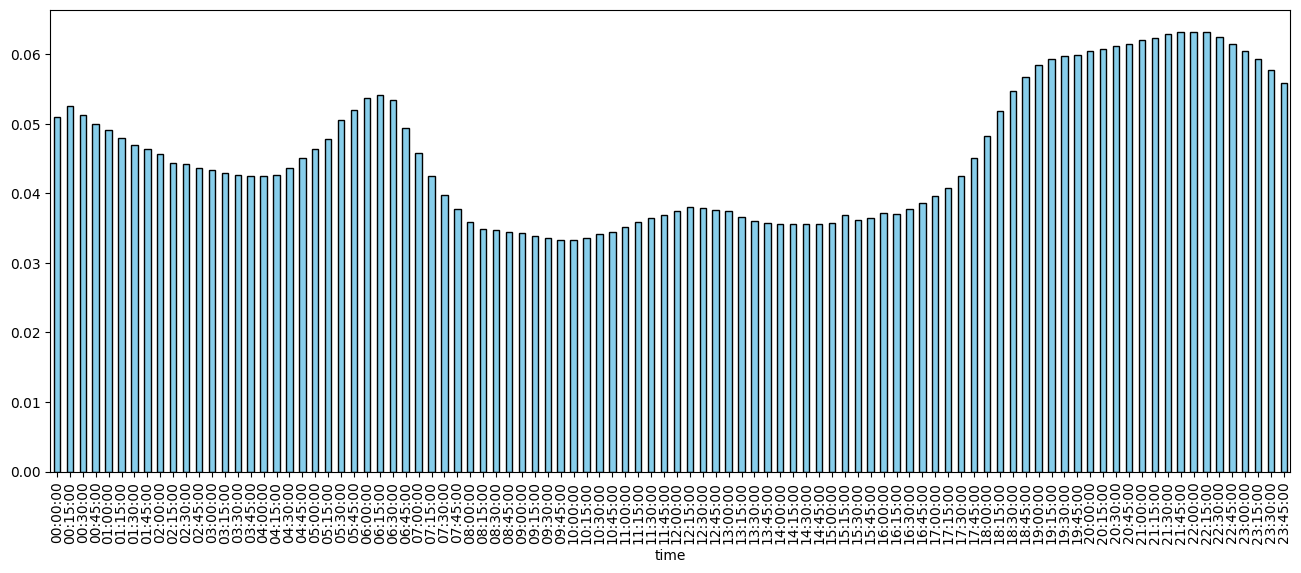

In [59]:
filtered_for_import = all_data_dense[all_data_dense['exportkwh(kwh)'] == 0]
daily_import = filtered_for_import.groupby('time')['importkwh(kwh)'].mean()
# GETTING RID OF THE NOICE
daily_import.loc['00:00:00'] = 00.051
plt.figure(figsize=(16, 6))
daily_import.plot( kind='bar', color='skyblue', edgecolor='black')

#### Daily Consumption Trend among different Socio-Ecomonic-Classes and different household sizes

/tmp/ipykernel_238373/1048205433.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_for_import['members'] = filtered_for_import['no_of_household_members'].apply(categorize_family_size)


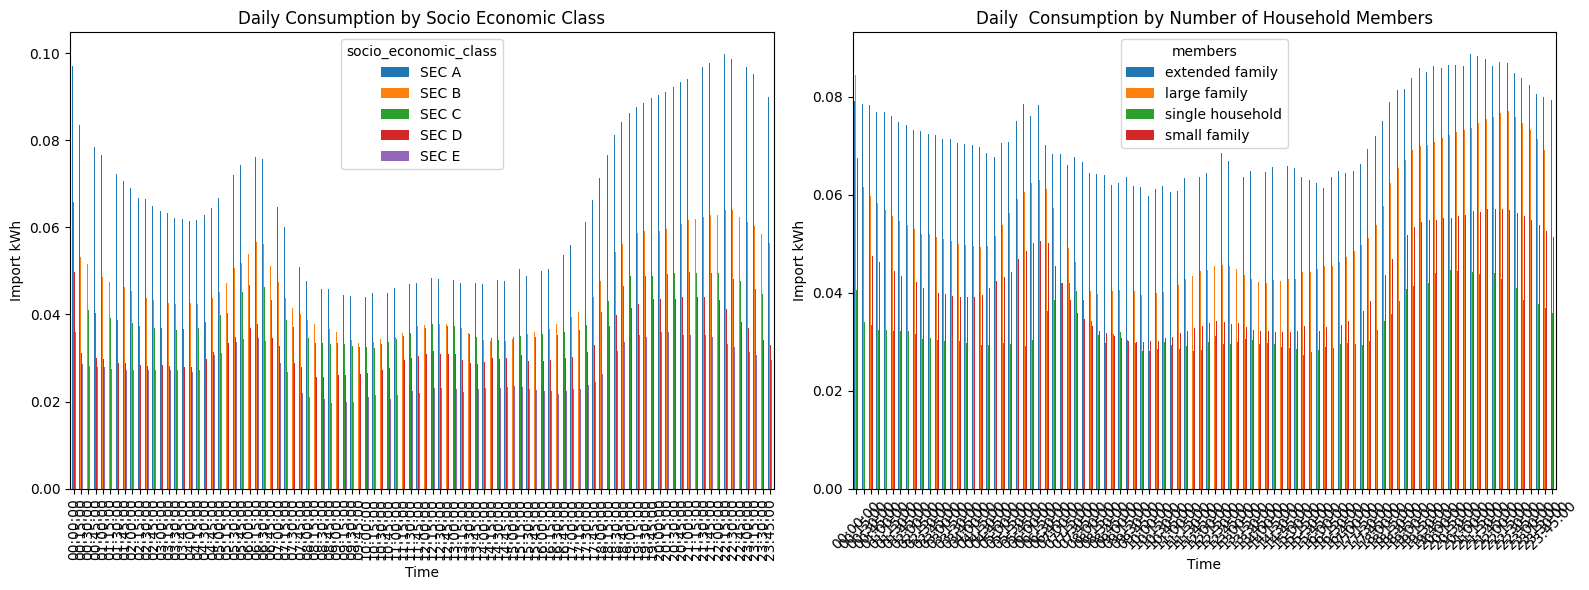

In [53]:
def categorize_family_size(members):
    if members >= 10:
        return 'extended family'
    elif 5 <= members < 10:
        return 'large family'
    elif 2 <= members < 5:
        return 'small family'
    else:
        return 'single household'

filtered_for_import = all_data_dense[all_data_dense['exportkwh(kwh)'] == 0]
filtered_for_import['members'] = filtered_for_import['no_of_household_members'].apply(categorize_family_size)
daily_import_SEC = filtered_for_import.groupby(['time', 'socio_economic_class'])['importkwh(kwh)'].mean().unstack()
daily_import_members = filtered_for_import.groupby(['time', 'members'])['importkwh(kwh)'].mean().unstack()


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

daily_import_SEC.plot(ax=ax[0], kind='bar')
ax[0].set_title("Daily Consumption by Socio Economic Class")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Import kWh')

daily_import_members.plot(ax=ax[1], kind='bar')
ax[1].set_title("Daily  Consumption by Number of Household Members")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Import kWh')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
#Create weight dictionary from daily_import
weights = {}
for i in range(len(daily_import)):
    weights[daily_import.index[i]] = daily_import[i]
weights = dict(sorted(weights.items(), key=lambda item: item[1], reverse=True))


/tmp/ipykernel_238373/4127387171.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights[daily_import.index[i]] = daily_import[i]


In [76]:
def impute_missing_with_weights(data, value_col='importkwh(kwh)', weight_dict=None):
        
    data = data.sort_values(['household_ID', 'DATETIME'])
    
    def impute_group(group):
        group = group.reset_index(drop=True)
        for i in range(len(group)):
            if pd.notnull(group.loc[i, value_col]):
                continue

            prev_idx = group.loc[:i-1, value_col].last_valid_index()
            next_idx = group.loc[i:, value_col].first_valid_index()

            if prev_idx is None or next_idx is None:
                continue

            prev_time = group.loc[prev_idx, 'DATETIME']
            next_time = group.loc[next_idx, 'DATETIME']
            consumption_diff = group.loc[next_idx, value_col] - group.loc[prev_idx, value_col]

            missing_indices = list(range(prev_idx + 1, next_idx))
            if not missing_indices:
                continue

            times = group.loc[missing_indices, 'DATETIME'].dt.time.astype(str)
            weight_values = [weight_dict.get(t, 0.0) for t in times]
            weight_sum = sum(weight_values)
            if weight_sum == 0:
                continue

            for idx, w in zip(missing_indices, weight_values):
                group.loc[idx, value_col] = group.loc[prev_idx, value_col] + (consumption_diff * w / weight_sum)
        
        return group

    data = data.groupby('household_ID', group_keys=False).apply(lambda g: impute_group(g))
    return data


imputed_data = impute_missing_with_weights(complete_data, value_col='importkwh(kwh)', weight_dict=weights)

/tmp/ipykernel_238373/1585299657.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('household_ID', group_keys=False).apply(lambda g: impute_group(g))


#### Step 02.01.02: General Daily Exportation Trend in Sri Lanka

<Axes: xlabel='time'>

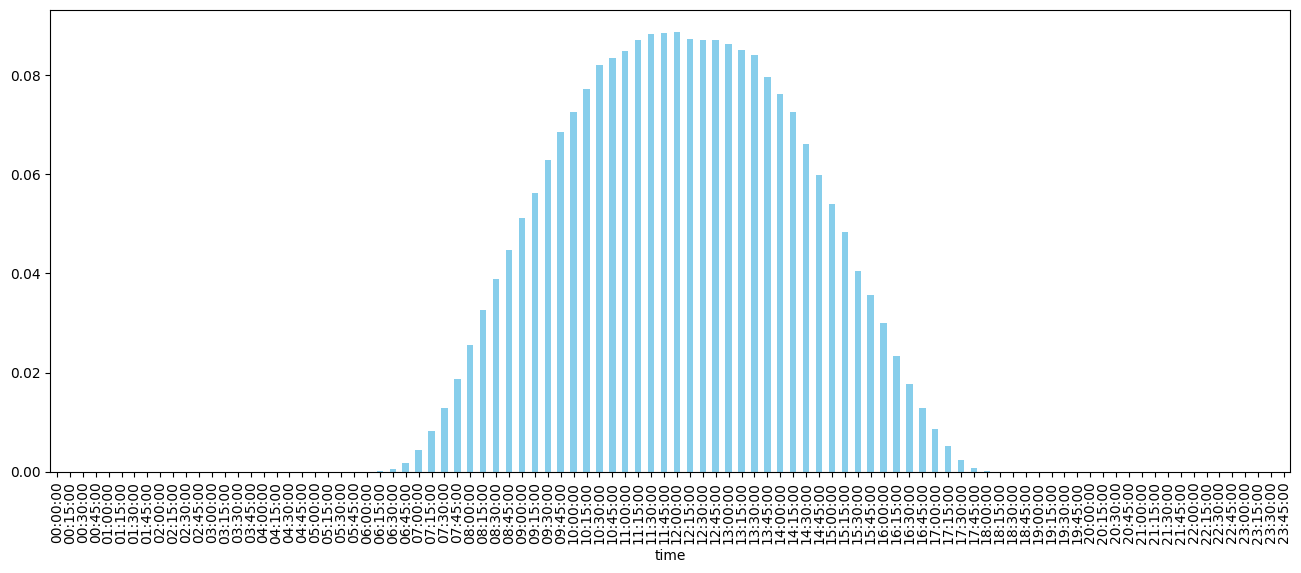

In [56]:
daily_export = all_data_dense.groupby('time')['exportkwh(kwh)'].mean()
# GETTING RID OF THE NOICE
daily_export.loc['00:00:00'] = 0
plt.figure(figsize=(16, 6))
daily_export.plot( kind='bar', color='skyblue')

### Imputation Completion

In [87]:
complete_data

,household_ID,DATETIME,date,time,importkwh(kwh),exportkwh(kwh)
0,ID0013,2024-04-19 01:30:00,2024-04-19,01:30:00,0.063,0.0
1,ID0013,2024-04-19 01:45:00,2024-04-19,01:45:00,0.060,0.0
2,ID0013,2024-04-19 02:00:00,2024-04-19,02:00:00,0.059,0.0
3,ID0013,2024-04-19 02:15:00,2024-04-19,02:15:00,0.026,0.0
4,ID0013,2024-04-19 02:30:00,2024-04-19,02:30:00,0.024,0.0
...,...,...,...,...,...,...
53669953,ID3820,2024-12-23 11:00:00,2024-12-23,11:00:00,0.055,0.0
53669954,ID3820,2024-12-23 11:15:00,2024-12-23,11:15:00,0.054,0.0
53669955,ID3820,2024-12-23 11:30:00,2024-12-23,11:30:00,0.052,0.0
53669956,ID3820,2024-12-23 11:45:00,2024-12-23,11:45:00,0.053,0.0


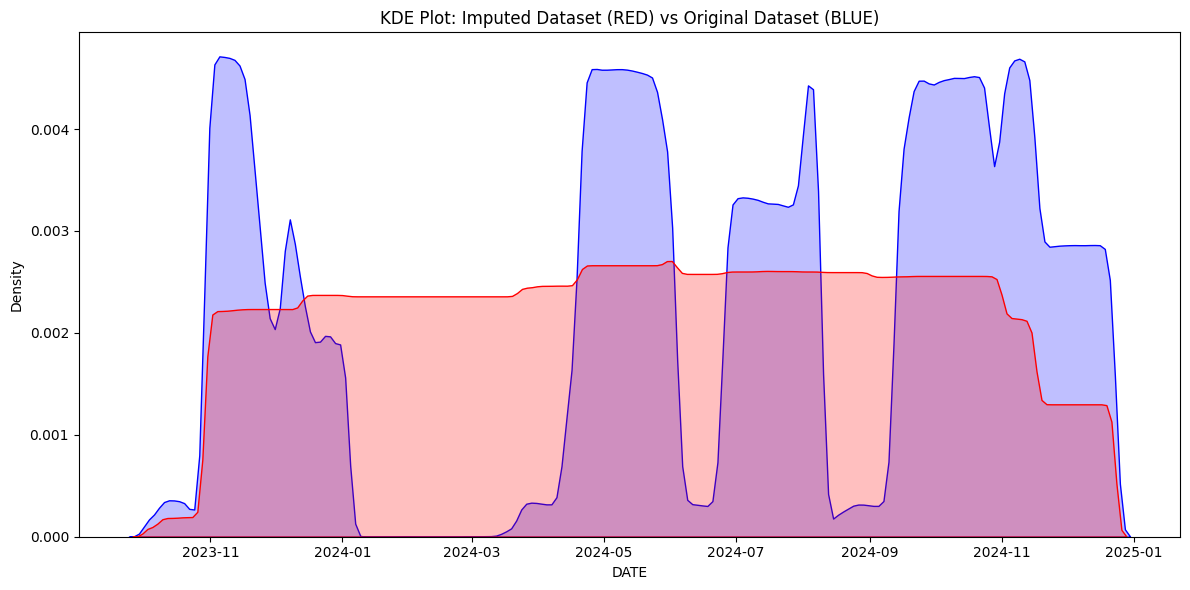

In [89]:
plt.figure(figsize=(12, 6))
sns.kdeplot(all_data_filtered['DATETIME'].dropna(), fill=True, color='blue', bw_adjust=0.5)
sns.kdeplot(complete_data['DATETIME'], fill=True, color='Red', bw_adjust=0.5)
plt.title('KDE Plot: Imputed Dataset (RED) vs Original Dataset (BLUE)')
plt.xlabel('DATE')
plt.ylabel('Density')
plt.tight_layout()
plt.show()